In [430]:
import pandas as pd
import numpy as np
import datetime as DT

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGION_CODES = ['LU']

%config InlineBackend.figure_format = 'retina'

In [431]:
path = 'data.csv'
states = pd.read_csv(path,
                     usecols=['date', 'state', 'positive'],
                     parse_dates=['date'],
                     index_col=['state', 'date'],
                     squeeze=True).sort_index()

In [432]:
state_name = 'LU'

def prepare_cases(cases, cutoff=25):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,    #7 days moving window for smoothing
        #win_type='gaussian',   #or comment whole line to have uniform
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

In [433]:
def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

In [434]:
cases = states.xs(state_name).rename(f"{state_name} cases")
original, smoothed = prepare_cases(cases)
#convert into array for easier handling
original_array = original.values
smoothed_array = smoothed.values


In [435]:
dates = smoothed.index
dates_detection = date2num(smoothed.index.tolist())

dates_infection = smoothed.index - DT.timedelta(days=9)
dates_infection = date2num(dates_infection.tolist())

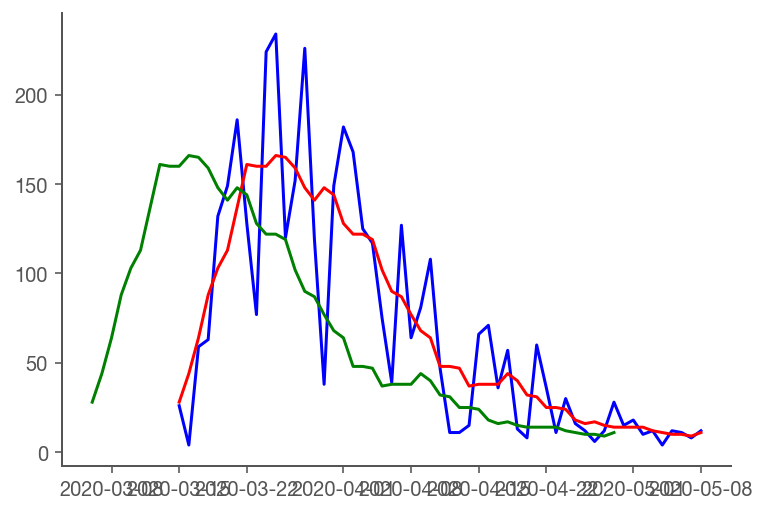

In [436]:
plt.plot_date(dates_detection, original_array,'b-')
plt.plot_date(dates_detection, smoothed_array,'r-')
plt.plot_date(dates_infection, smoothed_array,'g-')

In [437]:
R_T_MAX = 10
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

In [438]:
def get_posteriors(sr, date, sigma=0.15):

    # (1) Calculate Lambda
    gamma=1/np.random.normal(4, 0.5, len(r_t_range))
    lam = sr[:-1] * np.exp(gamma[:, None] * (r_t_range[:, None] - 1))
    #lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:], lam),
        index = r_t_range,
        columns = date[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=date,
        data={date[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(date[:-1], date[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed_array, dates, sigma=.15)    #optimal sigma already chosen in original Notebook

In [439]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.5)          # confidence bounds, p=50%

most_likely = posteriors.idxmax().rename('R_t-estimate')   #mean R_t value

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)            #global result for R_t-estimate
print(result.tail())

result.to_csv('/Users/daniele.proverbio/python-workspace/PhD/covid-19/R_t/R_t-estimation/plots_results/simulation_DanieleProverbio_20200508_Rt-estimate.csv')

            R_t-estimate  Low_50  High_50
date                                     
2020-05-04          0.70    0.36     0.88
2020-05-05          0.68    0.39     0.91
2020-05-06          0.69    0.34     0.88
2020-05-07          0.68    0.34     0.88
2020-05-08          0.78    0.44     1.00


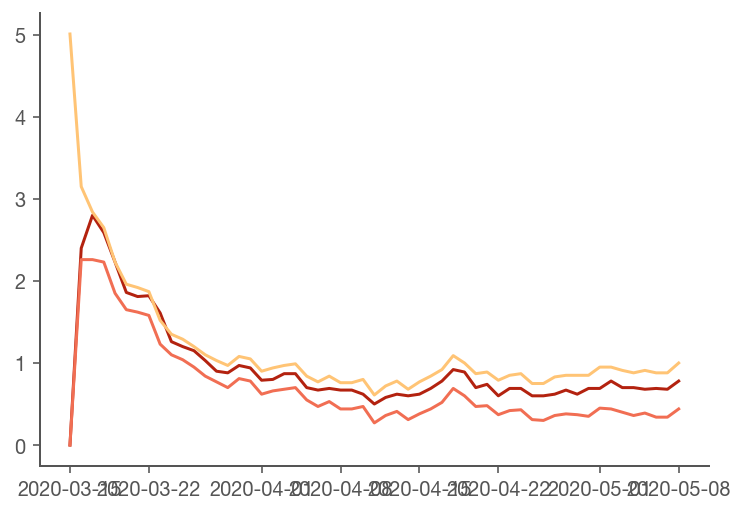

In [440]:
plt.plot(result)

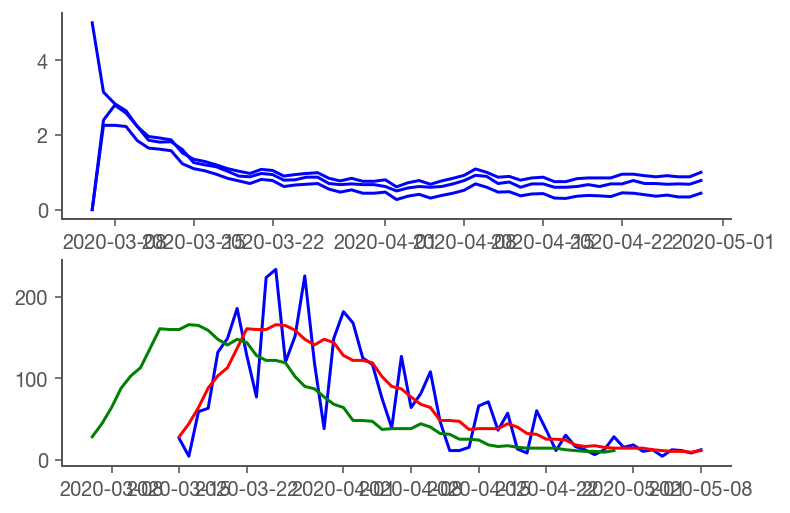

In [441]:
plt.subplot(211)
plt.plot_date(dates_infection,result.values,'b-')
plt.subplot(212)
plt.plot_date(dates_detection, original_array,'b-')
plt.plot_date(dates_detection, smoothed_array,'r-')
plt.plot_date(dates_infection, smoothed_array,'g-')

plt.show()

## "Nowcast"
Following Andreas' suggestion

In [442]:
smoothed1=smoothed.copy()
smoothed2=smoothed.copy()
smoothed3=smoothed.copy()

posteriors1=posteriors.copy()
posteriors2=posteriors.copy()
posteriors3=posteriors.copy()

log_likelihood1 = log_likelihood.copy()
log_likelihood2 = log_likelihood.copy()
log_likelihood3 = log_likelihood.copy()

hdis1=hdis.copy()
hdis2=hdis.copy()
hdis3=hdis.copy()

most_likely1=most_likely.copy()
most_likely2=most_likely.copy()
most_likely3=most_likely.copy()

result1=result.copy()
result2=result.copy()
result3=result.copy()

In [443]:
j=0
while j <7:
    new_date = smoothed1.index[-1]  + pd.Timedelta(days=1)
    smoothed1.loc[new_date]=round((smoothed1.values[-4]*(most_likely1.values[-1]+0)))
    smoothed2.loc[new_date]=round((smoothed2.values[-4]*(most_likely2.values[-1]+0.1)))
    smoothed3.loc[new_date]=round((smoothed3.values[-4]*(most_likely3.values[-1]+0.2)))
    
    j=j+1
    
    posteriors1, log_likelihood1 = get_posteriors(smoothed1.values, smoothed1.index, sigma=.15) 
    hdis1 = highest_density_interval(posteriors1, p=.5)  
    most_likely1 = posteriors1.idxmax().rename('R_t-estimate') 
    result1 = pd.concat([most_likely1, hdis1], axis=1)  
    
    posteriors2, log_likelihood2 = get_posteriors(smoothed2.values, smoothed2.index, sigma=.15) 
    hdis2 = highest_density_interval(posteriors2, p=.5)  
    most_likely2 = posteriors2.idxmax().rename('R_t-estimate') 
    result2 = pd.concat([most_likely2, hdis2], axis=1) 
    
    posteriors3, log_likelihood3 = get_posteriors(smoothed3.values, smoothed3.index, sigma=.15) 
    hdis3 = highest_density_interval(posteriors3, p=.5)  
    most_likely3 = posteriors3.idxmax().rename('R_t-estimate') 
    result3 = pd.concat([most_likely3, hdis3], axis=1) 

In [451]:
result3.tail(10)

,R_t-estimate,Low_50,High_50
date,,,
2020-05-06,0.68,0.34,0.89
2020-05-07,0.67,0.33,0.88
2020-05-08,0.80,0.45,1.02
2020-05-09,0.77,0.42,0.99
2020-05-10,0.80,0.49,1.06
2020-05-11,0.74,0.46,1.03
2020-05-12,0.80,0.53,1.11
2020-05-13,0.87,0.47,1.06
2020-05-14,0.87,0.49,1.08
